## **Bloque 1: Configuración e Instalación**

In [1]:
# Instalación de dependencias necesarias en el entorno de Kaggle
!pip install -q mne==1.6.0
!pip install -q braindecode==0.7
!pip install -q -U git+https://github.com/UN-GCPDS/python-gcpds.databases

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.signal import resample, filtfilt, butter
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from mne.decoding import CSP
from gcpds.databases import GIGA_MI_ME

# Descarga del dataset (si no está montado ya)
dggarciam94_giga_science_gcpds_path = kagglehub.dataset_download('dggarciam94/giga-science-gcpds')
print('Librerías y Dataset listos.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Librerías y Dataset listos.


## **Bloque 2: Funciones de Preprocesamiento y Carga (Optimizadas)**

Procesando Sujeto 1...
Procesando Sujeto 5...
Procesando Sujeto 14...


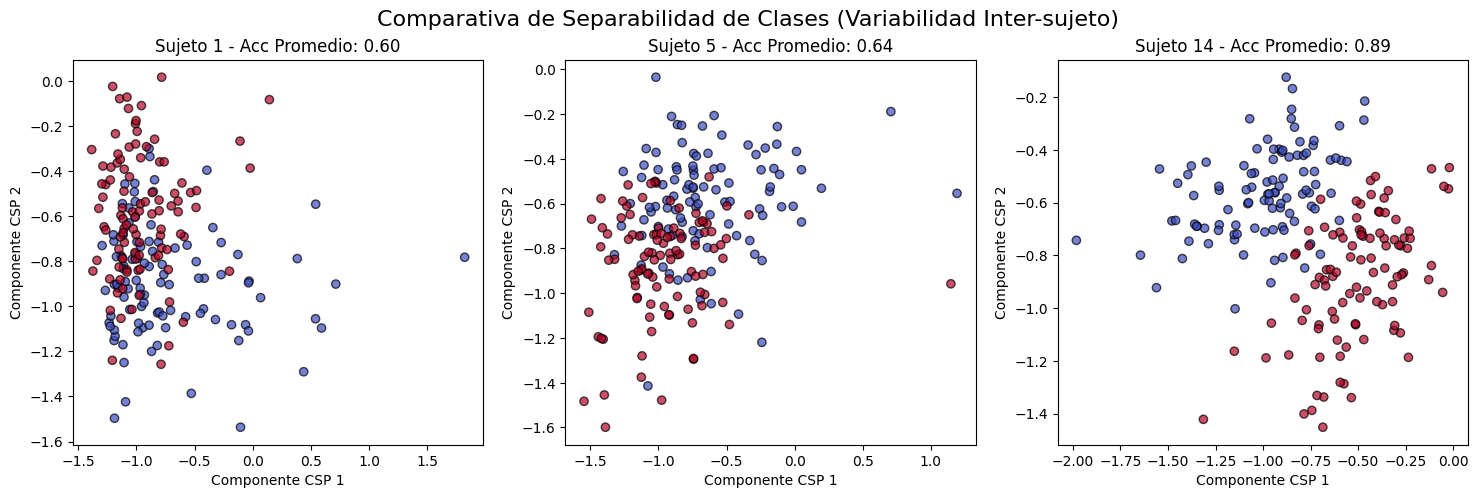

In [2]:
# --- Configuración de Canales ---
channels = ['Fp1','Fpz','Fp2', 'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8', 'O1','Oz','O2', 'Iz']

# --- Funciones Helper ---
def load_subject_data(db, sbj_id, classes=['left hand mi', 'right hand mi'], new_fs=256):
    """Carga, filtra espacialmente y re-muestrea los datos de un sujeto específico."""
    db.load_subject(sbj_id)
    X, y = db.get_data(classes=classes)
    
    # Selección de canales EEG
    index_eeg_chs = db.format_channels_selectors(channels=channels) - 1
    X = X[:, index_eeg_chs, :]
    
    # Resampling si es necesario
    fs_actual = db.metadata['sampling_rate']
    if new_fs != fs_actual:
        points = int((X.shape[-1] / fs_actual) * new_fs)
        X = resample(X, points, axis=-1)
        
    return X, y

def apply_bandpass(X, fs, low=8, high=30, order=5):
    """Aplica filtro Butterworth para aislar ritmos motores (Mu/Beta)."""
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, X, axis=-1)# Inicializar base de datos
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
fs_target = 256

# Seleccionamos sujetos que suelen tener comportamientos distintos
# Algunos sujetos tienen muy buena "imaginación motora", otros sufren de "BCI Illiteracy"
subjects_to_compare = [1, 5, 14] 

results = {}
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, sbj in enumerate(subjects_to_compare):
    print(f"Procesando Sujeto {sbj}...")
    
    # 1. Carga y Filtrado (8-30Hz para capturar Mu y Beta)
    X, y = load_subject_data(db, sbj, new_fs=fs_target)
    X_filt = apply_bandpass(X, fs_target, low=8, high=30)
    
    # 2. Pipeline CSP + Clasificación
    # Usamos CSP para encontrar los filtros espaciales que maximizan la varianza entre clases
    csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)
    clf = make_pipeline(csp, StandardScaler(), SVC(kernel='linear'))
    
    # 3. Validación Cruzada para obtener Accuracy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_filt, y, cv=cv, scoring='accuracy')
    results[sbj] = np.mean(scores)
    
    # 4. Visualización de la dispersión (Scatter Plot de características CSP)
    X_csp = csp.fit_transform(X_filt, y)
    axes[i].scatter(X_csp[:, 0], X_csp[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
    axes[i].set_title(f'Sujeto {sbj} - Acc Promedio: {np.mean(scores):.2f}')
    axes[i].set_xlabel('Componente CSP 1')
    axes[i].set_ylabel('Componente CSP 2')

plt.suptitle("Comparativa de Separabilidad de Clases (Variabilidad Inter-sujeto)", fontsize=16)
plt.show()

## **Bloque 3: Análisis de Variabilidad entre Sujetos (El núcleo del ejercicio)**

Procesando Sujeto 1...
Procesando Sujeto 5...
Procesando Sujeto 14...


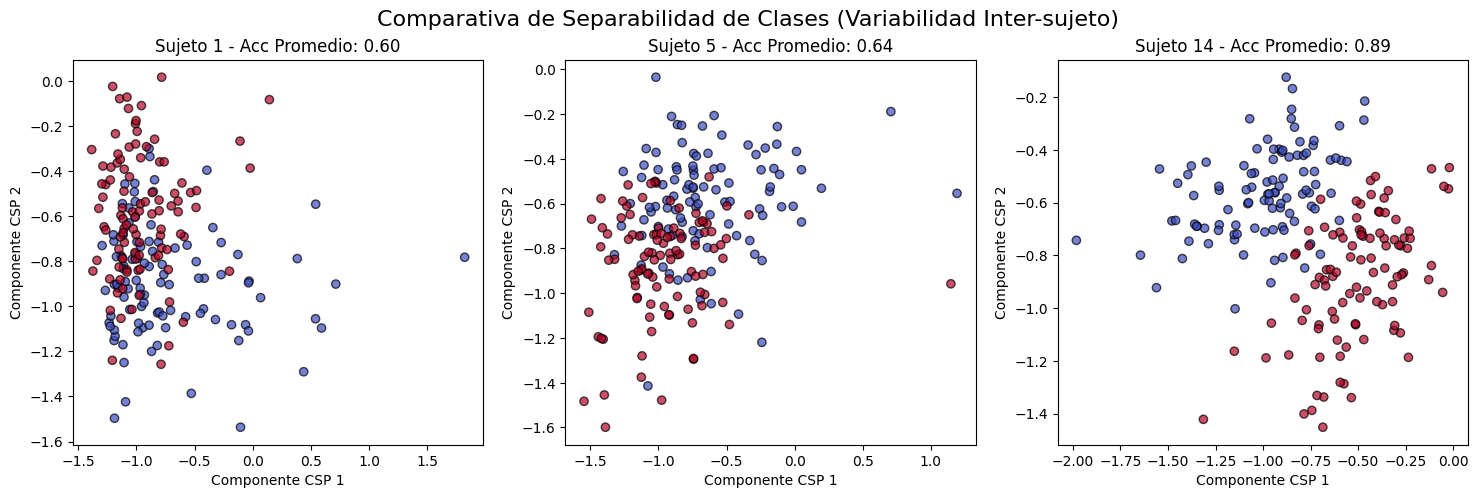

In [3]:
# Inicializar base de datos
db = GIGA_MI_ME('/kaggle/input/giga-science-gcpds/GIGA_MI_ME')
fs_target = 256

# Seleccionamos sujetos que suelen tener comportamientos distintos
# Algunos sujetos tienen muy buena "imaginación motora", otros sufren de "BCI Illiteracy"
subjects_to_compare = [1, 5, 14] 

results = {}
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, sbj in enumerate(subjects_to_compare):
    print(f"Procesando Sujeto {sbj}...")
    
    # 1. Carga y Filtrado (8-30Hz para capturar Mu y Beta)
    X, y = load_subject_data(db, sbj, new_fs=fs_target)
    X_filt = apply_bandpass(X, fs_target, low=8, high=30)
    
    # 2. Pipeline CSP + Clasificación
    # Usamos CSP para encontrar los filtros espaciales que maximizan la varianza entre clases
    csp = CSP(n_components=2, reg=None, log=True, norm_trace=False)
    clf = make_pipeline(csp, StandardScaler(), SVC(kernel='linear'))
    
    # 3. Validación Cruzada para obtener Accuracy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_filt, y, cv=cv, scoring='accuracy')
    results[sbj] = np.mean(scores)
    
    # 4. Visualización de la dispersión (Scatter Plot de características CSP)
    X_csp = csp.fit_transform(X_filt, y)
    axes[i].scatter(X_csp[:, 0], X_csp[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
    axes[i].set_title(f'Sujeto {sbj} - Acc Promedio: {np.mean(scores):.2f}')
    axes[i].set_xlabel('Componente CSP 1')
    axes[i].set_ylabel('Componente CSP 2')

plt.suptitle("Comparativa de Separabilidad de Clases (Variabilidad Inter-sujeto)", fontsize=16)
plt.show()

## **Bloque 4 - Discusión: Factores de Variabilidad en Señales EEG**

Como se observa en las gráficas anteriores, el rendimiento del algoritmo (CSP + SVM) varía significativamente entre sujetos (ej. Sujeto 1 vs Sujeto 5). Esto se debe a varios factores intrínsecos y extrínsecos:

1.  **Factores Anatómicos:** El grosor del cráneo y la orientación de las columnas corticales varían entre personas. Esto altera cómo se proyecta el campo eléctrico sobre los electrodos (volumen de conducción), haciendo que los patrones espaciales sean únicos para cada individuo.
2.  **Estrategias Cognitivas:** La "Imaginación Motora" es subjetiva. Un sujeto puede imaginar "apretar una pelota" (kinestésico) mientras que otro imagina "ver su mano moverse" (visual). La imaginación kinestésica suele activar mejor la corteza sensoriomotora (ritmos Mu), mientras que la visual activa zonas occipitales, confundiendo al clasificador.
3.  **Experiencia Previa:** Sujetos con entrenamiento previo en BCI o actividades motoras finas (músicos, deportistas) tienden a generar una desincronización (ERD) más fuerte y clara que usuarios novatos.

## **Bloque 5: Análisis de Artefactos Fisiológicos**

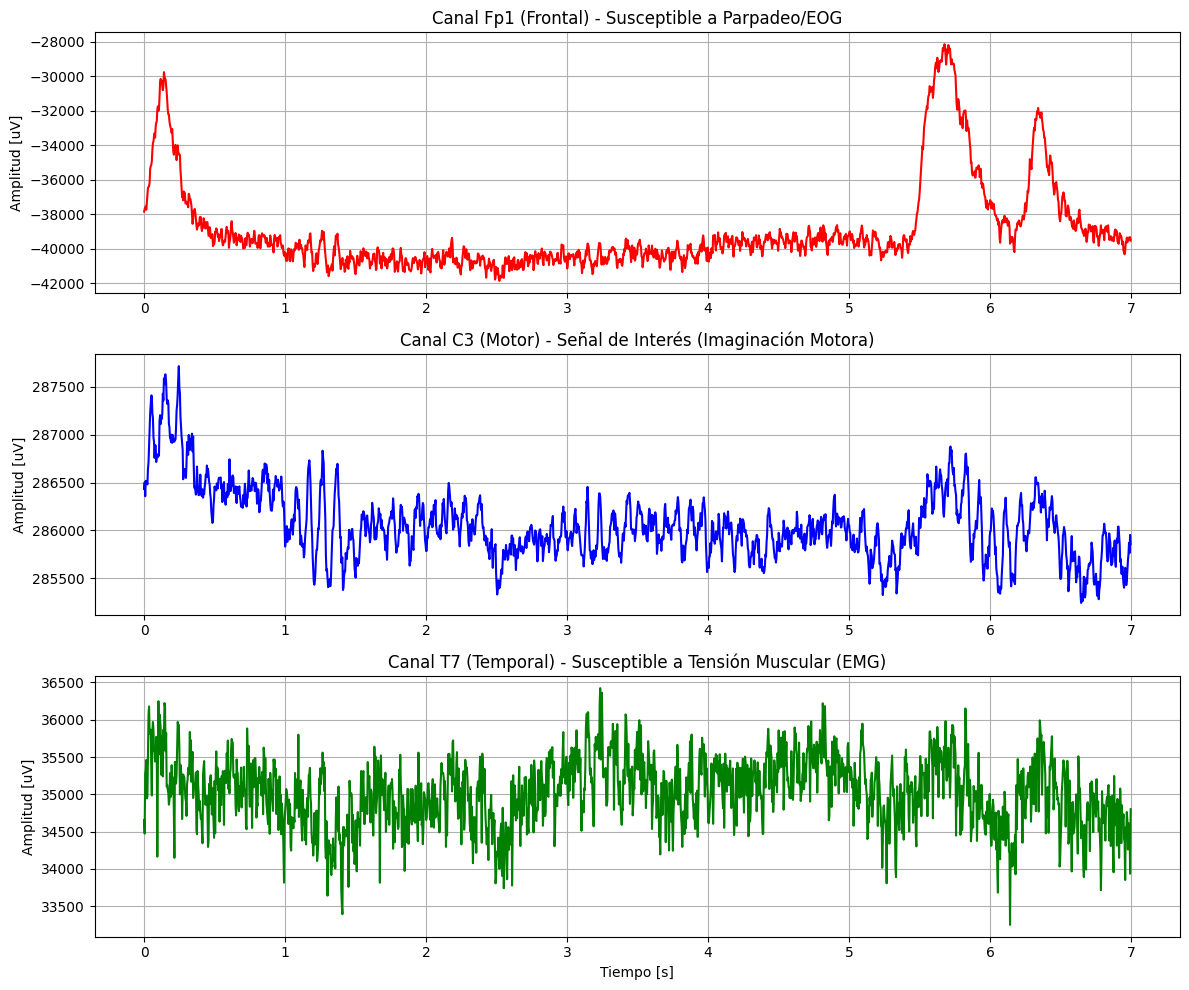

In [4]:
# Vamos a analizar un sujeto y buscar "ruido"
sbj_noise = 1 
# Cargamos datos sin filtrar espacialmente aún para ver los artefactos crudos
X_raw, y_raw = load_subject_data(db, sbj_noise, new_fs=fs_target)

# Definimos canales de interés
# Fp1: Muy sensible al parpadeo (EOG - Electrooculograma)
# C3: Corteza motora (Señal de interés)
# T7: Región temporal, muy sensible a tensión de mandíbula (EMG - Electromiograma)
ch_indices = [channels.index('Fp1'), channels.index('C3'), channels.index('T7')]

# Vector de tiempo
time_vector = np.arange(X_raw.shape[2]) / fs_target

# Tomamos un trial aleatorio donde se vea ruido (puedes probar con trial 10, 15, etc.)
trial_idx = 10 

plt.figure(figsize=(12, 10)) # Aumentamos el alto de la figura para que quepan 3 gráficas

# 1. Graficar Fp1 (Ojos)
plt.subplot(3, 1, 1)
plt.plot(time_vector, X_raw[trial_idx, ch_indices[0], :], color='red')
plt.title(f'Canal Fp1 (Frontal) - Susceptible a Parpadeo/EOG')
plt.ylabel('Amplitud [uV]')
plt.grid(True)

# 2. Graficar C3 (Motor)
plt.subplot(3, 1, 2)
plt.plot(time_vector, X_raw[trial_idx, ch_indices[1], :], color='blue')
plt.title(f'Canal C3 (Motor) - Señal de Interés (Imaginación Motora)')
plt.ylabel('Amplitud [uV]')
plt.grid(True)

# 3. Graficar T7 (Músculo/Mandíbula) - NUEVO
plt.subplot(3, 1, 3)
plt.plot(time_vector, X_raw[trial_idx, ch_indices[2], :], color='green')
plt.title(f'Canal T7 (Temporal) - Susceptible a Tensión Muscular (EMG)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [uV]')
plt.grid(True)

plt.tight_layout()
plt.show()

### **Bloque 6: Análisis de Artefactos Fisiológicos y su Impacto**

En la gráfica temporal superior, correspondiente al **Sujeto 1** (el de menor desempeño, Acc=0.60), se evidencia claramente la presencia de **artefactos oculares (EOG)**.

* **Evidencia Visual:** En el canal **Fp1** (línea roja), observamos cambios bruscos de amplitud masiva en los segundos **5.5 y 6.3**. Estos picos son característicos del parpadeo involuntario.
* **Comparación de Escala:** La señal del parpadeo es de un orden de magnitud muy superior a la señal de imaginación motora en **C3** (línea azul). Mientras el cerebro genera potenciales de $\approx 10-50 \mu V$, el movimiento ocular genera potenciales de cientos de microvoltios.
* **Impacto en la Clasificación:** Dado que el algoritmo CSP utiliza la covarianza de todos los canales, estos picos de energía en la zona frontal distorsionan los filtros espaciales. El clasificador no logra distinguir si la señal proviene de la corteza motora (intención de movimiento) o de un movimiento ocular, lo que resulta en la baja separabilidad de clases observada en la sección anterior para este sujeto.

Además de los artefactos mostrados, la literatura sugiere otros factores determinantes en la variabilidad observada entre el Sujeto 1 y el 14:

  * **Factores Genéticos:** Investigaciones sugieren que la concentración de neuroquímicos (como la dopamina) y la estructura de las conexiones de materia blanca influyen en la capacidad de modulación de los ritmos cerebrales. Un sujeto con predisposición genética favorable generará patrones SMR más robustos.
  * **Experiencia Previa:** La plasticidad cerebral juega un rol clave. Usuarios que han realizado tareas de imaginación motora antes, o que practican deportes/instrumentos, tienen redes neuronales motoras más eficientes, lo que facilita la clasificación por parte del algoritmo CSP.

**Conclusión Final**

La variabilidad entre sujetos observada en este estudio se atribuye a:
1.  **Factores Fisiológicos:** La presencia de artefactos no cerebrales (como el parpadeo severo en el Sujeto 1) que "ensucian" la señal.
2.  **Factores Cognitivos:** La capacidad de modulación de los ritmos sensoriomotores (SMR) varía; el Sujeto 14 muestra una clara desincronización (ERD), mientras que el Sujeto 1 podría estar sufriendo de fatiga, falta de concentración o "analfabetismo BCI" (*BCI Illiteracy*).
3.  **Solución Propuesta:** Para mitigar esto en aplicaciones reales, se recomienda implementar etapas de preprocesamiento avanzadas como **ICA (Análisis de Componentes Independientes)** para eliminar el EOG sin perder datos, o utilizar métodos de **Transfer Learning** para adaptar el modelo a las características específicas de cada sujeto.